# Calculating $\sigma_{\epsilon} / \epsilon$ for leptons

This notebook aims to calculate the uncertainty on the cross section from lepton efficiency. We construct this uncertainty from $\sigma_{\epsilon}$ the uncertainty from the lepton efficiency.

We can calcuate the uncertainty from lepton efficiency using the following function: 
$$\sigma_{\epsilon} = \sqrt{\frac{\epsilon (1 - \epsilon)}{N}}$$

Where $\epsilon$ is $\frac{N_{t}} {N_{l}}$. $N_{t}$ are the number of events that have a probed lepton passing tight selection cuts and $N_{l}$ are the number of events with a loose lepton.  The maximum number of $N_{t}$ is $N_{l}$, see the <a href="https://twiki.cern.ch/twiki/bin/view/CMSPublic/TagAndProbe">tag and probe method</a>.  $N$ from our uncertainty function is $N_{l}$.


## Materials

We get our efficencies from the muon and electron POG's muon and electron id selection efficiencies. We use the DATA efficiencies. We estimate $N$ using the following function: 

$$N = \epsilon^{-1} * N_{MC} * S $$

$N_{MC}$ are the number of events from Drell Yan Monte Carlo that pass tight selection. S is a scale factor such that we normalize the events to data. 


In [1]:
#Set up
import os, sys
sys.path.append(os.getcwd() + "/../")
from prep_ana_II import *
sys.path.append(os.getcwd() + "/../tools/")
from lepton_eff import muonEff, electronEff

import matplotlib
matplotlib.rcParams.update({'font.size': 22})

import warnings
warnings.filterwarnings('ignore')

Welcome to JupyROOT 6.10/00
Loading binning options...
Loading plotting options
unc_mc_process and scales are parameter dictionaries


In [2]:
%matplotlib inline

In [3]:
df = rp.read_root("../data/WWpt/ww_complete.root", columns=["mu_id_weight", "el1_id_weight", "el2_id_weight",
                                                                "lep1_type", "lep2_type", "lep1_eta", "lep2_eta",
                                                                "lep1_pt", "lep2_pt",])
#df = rp.read_root("../data/leptonEfficiencies/dyjetstoll_m-50_complete.root", columns=["mu_id_weight", "el1_id_weight", "el2_id_weight",
#                                                                "lep1_type", "lep2_type", "lep1_eta", "lep2_eta",
#                                                                "lep1_pt", "lep2_pt", "mll"])
warnings.filterwarnings('ignore')

Warning in <TStreamerInfo::BuildCheck>: 
   The StreamerInfo of class string read from file ../data/WWpt/ww_complete.root
   has the same version (=2) as the active class but a different checksum.
   You should update the version to ClassDef(string,3).
   Do not try to write objects with the current class definition,
   the files will not be readable.

Warning in <TStreamerInfo::CompareContent>: The following data member of
the in-memory layout version 2 of class 'string' is missing from 
the on-file layout version 2:
   string::_Alloc_hider _M_dataplus; //
Warning in <TStreamerInfo::CompareContent>: The following data member of
the in-memory layout version 2 of class 'string' is missing from 
the on-file layout version 2:
   unsigned long _M_string_length; //
Warning in <TStreamerInfo::CompareContent>: The following data member of
the in-memory layout version 2 of class 'string' is missing from 
the on-file layout version 2:
   string::(anonymous) ; //


# Muons

Outline:
- Look at eta and pt distributions
- Obtain muon id efficiencies of data using drell yan monte carlo 
- Plot efficiencies and $\sigma_{\epsilon}$ in windows and eta and pt

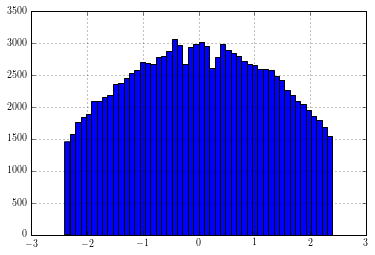

In [4]:
df[(df.lep1_type == 13) & (df.lep2_type == 13)].lep1_eta.hist(bins=50)

## Kinematics

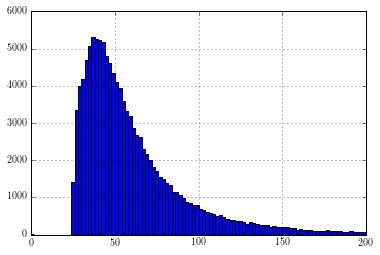

In [5]:
df[(df.lep1_type == 13) & (df.lep2_type == 13)].lep1_pt.hist(range=(0, 200), bins=100)

## Data Efficiency Distributions

In [24]:
df = df[(df.lep1_type == 13) & (df.lep2_type == 13)].reset_index()

temp_list = muonEff(list(df.lep1_pt.values), list(df.lep1_eta.values))
tmp_df = pd.DataFrame(np.array(temp_list), columns=["eff", "high_err", "low_err"])

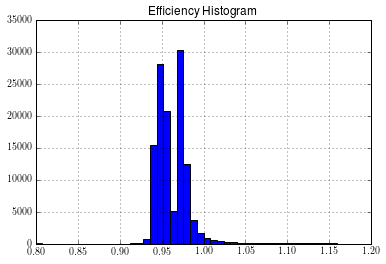

In [25]:
# Histogram of efficiency
tmp_df.eff.hist( range=(.8, 1.2), bins=50)
plt.title("Efficiency Histogram")

In [26]:
pt = [ (25., 30.), (30., 40.), (40., 50.), (50., 60.), (60., 200.)]
abs_eta = [(0., 0.9), (0.9, 1.2), (1.2, 2.1), (2.1, 2.4)]

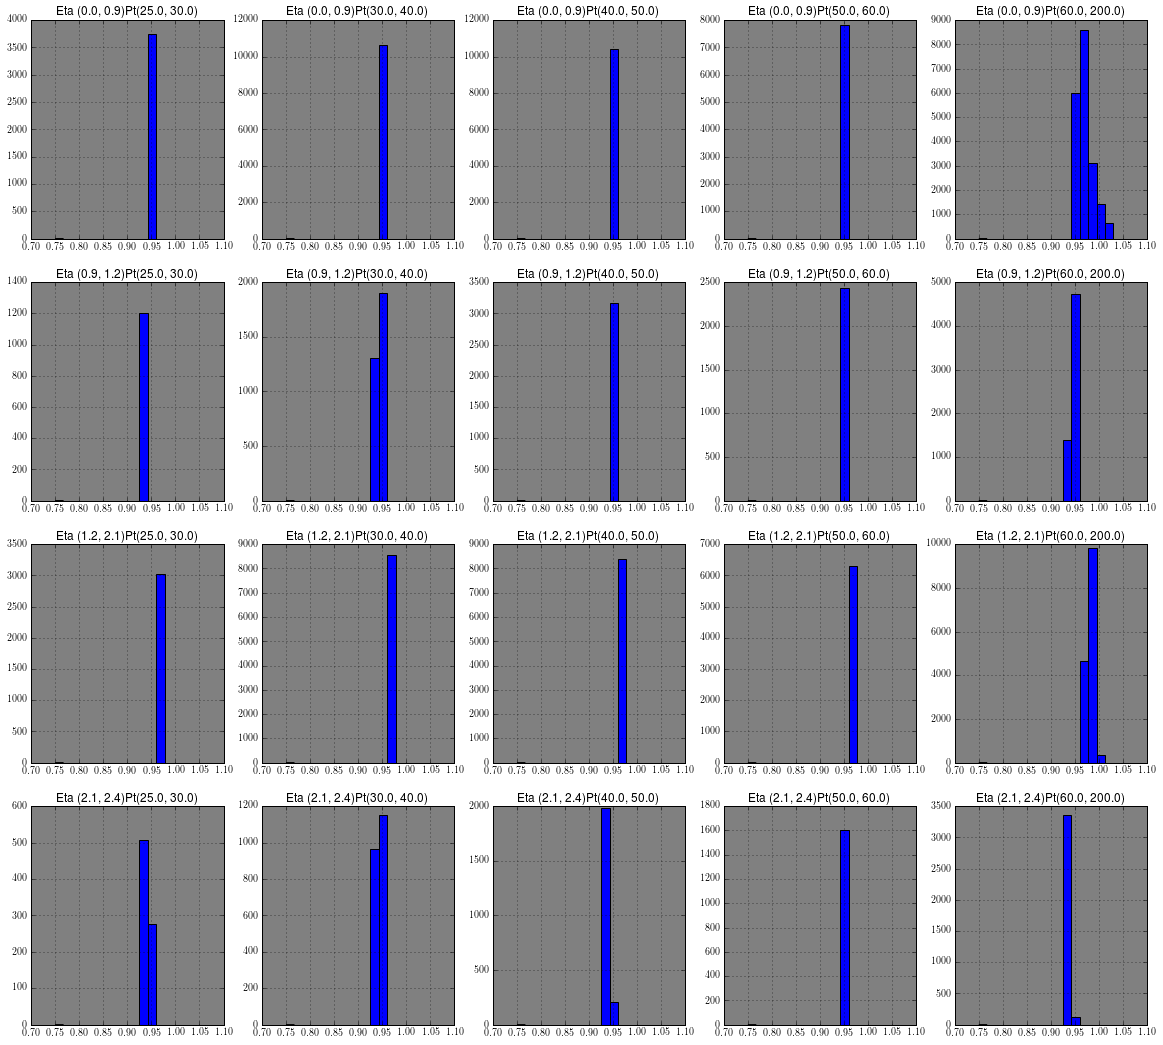

In [27]:
fig, axes = plt.subplots(len(abs_eta), len(pt), figsize=(20, 18));

for it, eta_it in enumerate(abs_eta):
    for jt, pt_jt in enumerate(pt):
        eta_cut = (df.lep1_eta.abs() >= eta_it[0]) & (df.lep1_eta.abs() < eta_it[1]) 
        tmp_df[(df.lep1_pt >= pt_jt[0]) & (df.lep1_pt < pt_jt[1])  & eta_cut ].eff.hist(  range=(.75, 1.1), bins=20, ax=axes[it][jt])
    
        axes[it][jt].patch.set_facecolor((.5,.5,.5))
        axes[it][jt].set_title( "Eta " + str(abs_eta[it]) + "Pt" + str(pt_jt)  )

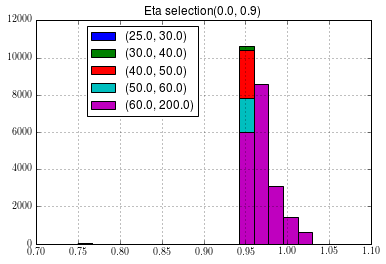

In [28]:
# Look at the windows indivisually
eta_it = 0
for i in pt:
    eta_cut = (df.lep1_eta.abs() >= abs_eta[eta_it][0]) & (df.lep1_eta.abs() < abs_eta[eta_it][1]) 
    tmp_df[(df.lep1_pt >= i[0]) & (df.lep1_pt < i[1]) & (df.lep1_type == 13) & eta_cut ].eff.hist(  range=(.75, 1.1), bins=20)
    
plt.legend([str(i) for i in pt ], bbox_to_anchor=(0.5, 1))
plt.title( "Eta selection" + str(abs_eta[eta_it]))

## Efficiency uncertainty

No matter the label we are currently looking at a drell yan sample. 

In [29]:
another_list = []

for eta_it in abs_eta: 
    for pt_jt in pt:
        eta_cut = (df.lep1_eta.abs() >= eta_it[0]) & (df.lep1_eta.abs() < eta_it[1]) 
        pt_cut = (df.lep1_pt >= pt_jt[0]) & (df.lep1_pt < pt_jt[1])
        
        #Calculate the mean epsilon for window
        epsilon = tmp_df[ (df.lep1_type == 13) & eta_cut & pt_cut ].eff.mean()
        
        #Calculate N_l
        N_MC_l = tmp_df[ (df.lep1_type == 13) & eta_cut & pt_cut ].shape[0] 
        N_l = epsilon**-1 * N_MC_l * scales["DYJetsToLL_M-50"]
        
        #simga
        simga_epsilon = ( epsilon * (1 - epsilon) / N_l )**.5
        uncertainty = simga_epsilon / epsilon
        
        print eta_it, pt_jt, epsilon, N_l,
        print simga_epsilon, uncertainty
        another_list.append( uncertainty )


(0.0, 0.9) (25.0, 30.0) 0.949954508382 10701.7405396 0.00210768971032 0.00221872699347
(0.0, 0.9) (30.0, 40.0) 0.951782023317 30352.268846 0.00122963908775 0.00129193350749
(0.0, 0.9) (40.0, 50.0) 0.951964863334 29733.3510276 0.0012401323762 0.00130270813973
(0.0, 0.9) (50.0, 60.0) 0.952011631713 22269.6905769 0.00143229352135 0.00150449161926
(0.0, 0.9) (60.0, 200.0) 0.971044434848 55167.2612094 0.000713912297255 0.000735200441539
(0.9, 1.2) (25.0, 30.0) 0.937594461997 3477.22967698 0.00410206363998 0.00437509371722
(0.9, 1.2) (30.0, 40.0) 0.94248822759 9234.06627759 0.00242281274418 0.00257065571034
(0.9, 1.2) (40.0, 50.0) 0.94568227121 9096.66906458 0.0023763052479 0.00251279454024
(0.9, 1.2) (50.0, 60.0) 0.947926110474 6981.7552276 0.00265897921354 0.00280504902667
(0.9, 1.2) (60.0, 200.0) 0.94434950466 17595.2331624 0.00172823733309 0.00183008232076
(1.2, 2.1) (25.0, 30.0) 0.97082078232 8447.28339041 0.00183125077799 0.00188629128191
(1.2, 2.1) (30.0, 40.0) 0.973286751558 23844.04

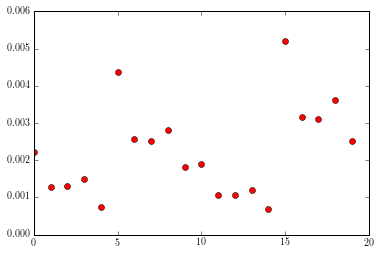

In [30]:
plt.plot([i for i in xrange(len(another_list))], another_list, 'ro')


## From POG

Taking the error and eff from the physics group

### Single Muon

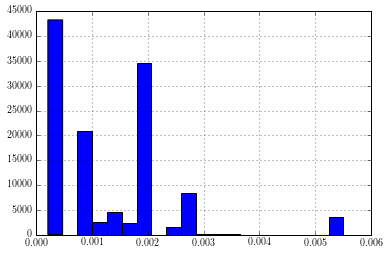

In [31]:
tmp_df["s_e_m1"] = ( (tmp_df.high_err + tmp_df.low_err) / 2 )/ tmp_df.eff
tmp_df.s_e.hist(bins=20).set_axis_bgcolor("grey")

### DiMuon

In [4]:
def gen_dilepton_unc(df, l1_typ = 13, l2_typ = 13):
    df_ = df[(df.lep1_type == l1_typ) & (df.lep2_type == l2_typ)].reset_index()

    #Renaming functions for convenience
    lep1Eff = electronEff
    if l1_typ == 13:
        lep1Eff = muonEff
        
    lep2Eff = electronEff
    if l2_typ == 13:
        lep2Eff = muonEff
    
    lep_1 = pd.DataFrame(np.array( lep1Eff(list(df_.lep1_pt.values), list(df_.lep1_eta.values)) ), columns=["eff_1", "high_err_1", "low_err_1"])  
    lep_2 = pd.DataFrame(np.array( lep2Eff(list(df_.lep2_pt.values), list(df_.lep2_eta.values)) ), columns=["eff_2", "high_err_2", "low_err_2"])  

    df_eff = pd.concat([lep_1, lep_2], axis=1)
    return df_eff

In [5]:
df_eff = gen_dilepton_unc(df)
s_1 = (df_eff.high_err_1 + df_eff.low_err_1) / 2
s_2 = (df_eff.high_err_2 + df_eff.low_err_2) / 2
df_eff["s_e"] = ( s_1**2 + s_2**2 )**.5 / ( df_eff.eff_1 * df_eff.eff_2)

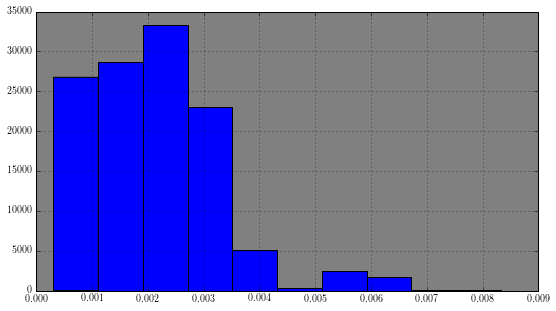

In [6]:
df_eff.s_e.hist( figsize=(9,5)).set_axis_bgcolor("grey")

# Electrons

## Kinematics

In [32]:
df = rp.read_root("../data/WWpt/ww_complete.root", columns=["mu_id_weight", "el1_id_weight", "el2_id_weight",
                                                                "lep1_type", "lep2_type", "lep1_eta", "lep2_eta",
                                                                "lep1_pt", "lep2_pt",])

df = df[(df.lep1_type == 11) & (df.lep2_type == 11)].reset_index()

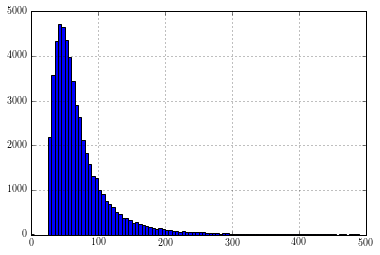

In [33]:
df[(df.lep1_type == 11) & (df.lep2_type == 11)].lep1_pt.hist(bins=100, range=(0,500))

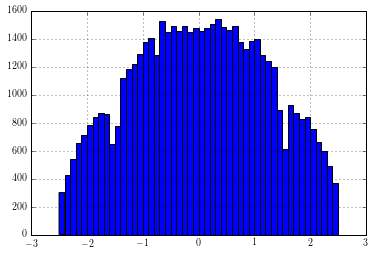

In [35]:
df[(df.lep1_type == 11) & (df.lep2_type == 11)].lep1_eta.hist(bins=50,)

## Data Efficiencies

In [36]:
pt = [  (20,50), (50, 100), (100, 200)]
abs_eta = [(-2.5, -2.0), (-2.0, -1.56), (-1.56, -1.442), (-1.4442, -1.), (-1.0, 0),
           (0, 1.0), (1.0, 1.442), (1.4442, 1.56), (1.56, 2.0), (2.0, 2.5)]

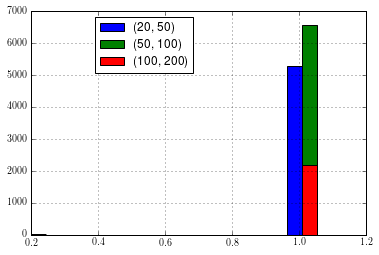

In [38]:
# electron 1 scale factors for eta [0, .5], along a pt spectrum 
eta_it = 4
for i in pt:
    eta_cut = (df.lep1_eta >= abs_eta[eta_it][0]) & (df.lep1_eta < abs_eta[eta_it][1]) 
    df[(df.lep1_pt >= i[0]) & (df.lep1_pt < i[1]) & (df.lep1_type == 11) & eta_cut ].el1_id_weight.hist(  range=(.2, 1.1), bins=20)
    
plt.legend([str(i) for i in pt ], bbox_to_anchor=(0.5, 1))

In [39]:
temp_list = electronEff(list(df.lep1_pt.values), list(df.lep1_eta.values))
tmp_e1_df = pd.DataFrame(np.array(temp_list), columns=["eff", "high_err", "low_err"])

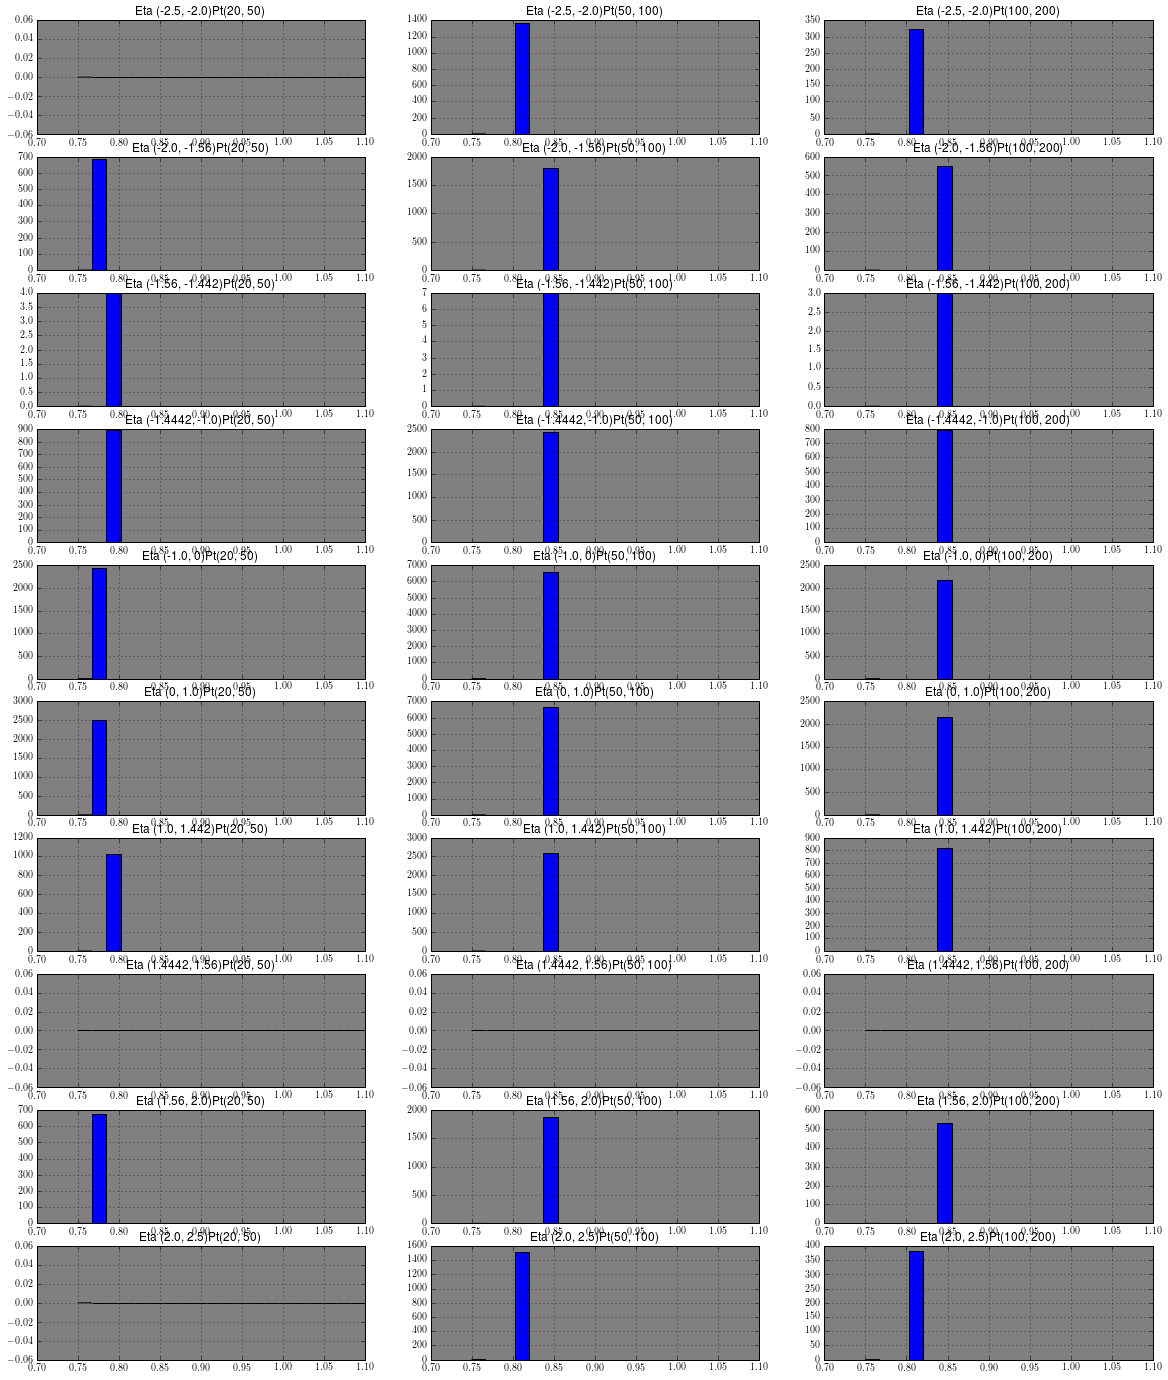

In [40]:
fig, axes = plt.subplots(len(abs_eta), len(pt), figsize=(20, 24));

for it, eta_it in enumerate(abs_eta):
    for jt, pt_jt in enumerate(pt):
        eta_cut = (df.lep1_eta >= eta_it[0]) & (df.lep1_eta < eta_it[1])
        type_cut = (df.lep1_type == 11) & (df.lep2_type == 11)
        tmp_e1_df[(df.lep1_pt >= pt_jt[0]) & (df.lep1_pt < pt_jt[1]) & type_cut & eta_cut ].eff.hist(  range=(.75, 1.1), bins=20, ax=axes[it][jt])
    
        axes[it][jt].patch.set_facecolor((.5,.5,.5))
        axes[it][jt].set_title( "Eta " + str(abs_eta[it]) + "Pt" + str(pt_jt)  )

In [43]:
another_list = []

for eta_it in abs_eta: 
    for pt_jt in pt:
        eta_cut = (df.lep1_eta >= eta_it[0]) & (df.lep1_eta < eta_it[1]) 
        pt_cut = (df.lep1_pt >= pt_jt[0]) & (df.lep1_pt < pt_jt[1])
        
        #lep_type
        lep_type = (df.lep1_type == 11) & (df.lep2_type == 11)
        
        #Calculate the mean epsilon for window
        epsilon = tmp_e1_df[ lep_type & eta_cut & pt_cut ].eff.mean()
        
        #Calculate N_l
        N_MC_l = tmp_e1_df[ lep_type & eta_cut & pt_cut ].shape[0] 
        N_l = epsilon**-1 * N_MC_l * scales["DYJetsToLL_M-50"]
        
        #simga
        simga_epsilon = ( epsilon * abs(1 - epsilon) / N_l )**.5
        uncertainty = simga_epsilon / epsilon
        
        print eta_it, pt_jt, epsilon, N_MC_l,
        print simga_epsilon, uncertainty
        another_list.append( uncertainty )

(-2.5, -2.0) (20, 50) 0.670320751731 901 0.00778239684374 0.0116099595957
(-2.5, -2.0) (50, 100) 0.813000023365 1365 0.00577553615276 0.00710398030354
(-2.5, -2.0) (100, 200) 0.813000023365 324 0.0118545787851 0.0145812772994
(-2.0, -1.56) (20, 50) 0.723799986197 1300 0.00640333230668 0.00884682568222
(-2.0, -1.56) (50, 100) 0.842000007629 1806 0.00478001273467 0.00567697469283
(-2.0, -1.56) (100, 200) 0.842000007629 550 0.00866176869079 0.0102871361191
(-1.56, -1.442) (20, 50) 0.585524037194 208 0.0158639025679 0.0270935120681
(-1.56, -1.442) (50, 100) 0.70630619755 307 0.0132592365462 0.01877264647
(-1.56, -1.442) (100, 200) 0.708437508345 80 0.0259579073577 0.036641068622
(-1.4442, -1.0) (20, 50) 0.741149988134 1887 0.00526855537104 0.00710862235093
(-1.4442, -1.0) (50, 100) 0.847999989986 2441 0.00406144955897 0.00478944529119
(-1.4442, -1.0) (100, 200) 0.847999989986 794 0.00712122491104 0.00839767098483
(-1.0, 0) (20, 50) 0.73789876325 5285 0.00315395955579 0.0042742442634
(-1.0,

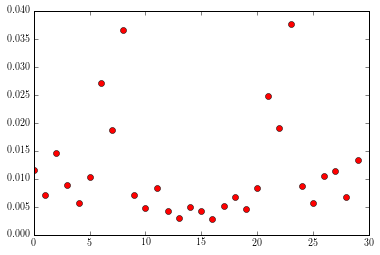

In [44]:
plt.plot([i for i in xrange(len(another_list))], another_list, 'ro')


## ...

In [54]:
tmp_e1_df["s_e_ele1"] = ((tmp_e1_df.high_err + tmp_e1_df.low_err) / 2) / tmp_e1_df.eff
tmp_e1_df.s_e.hist(bins=20).set_axis_bgcolor("grey")

NameError: name 'tmp_e1_df' is not defined

## Dielectron

In [ ]:
"""
#For your old man brain
def gen_dilepton_unc(df, l1_typ = 13, l2_typ = 13):
    df_ = df[(df.lep1_type == l1_typ) & (df.lep2_type == l2_typ)].reset_index()

    #Renaming functions for convenience
    lep1Eff = electronEff
    if l1_typ == 13:
        lep1Eff = muonEff
        
    lep2Eff = electronEff
    if l2_typ == 13:
        lep2Eff = muonEff
    
    lep_1 = pd.DataFrame(np.array( lep1Eff(list(df.lep1_pt.values), list(df.lep1_eta.values)) ), columns=["eff_1", "high_err_1", "low_err_1"])  
    lep_2 = pd.DataFrame(np.array( lep2Eff(list(df.lep2_pt.values), list(df.lep2_eta.values)) ), columns=["eff_2", "high_err_2", "low_err_2"])  

    df_eff = pd.concat([lep_1, lep_2], axis=1)
    return df_eff
"""

In [33]:
df_eff_el = gen_dilepton_unc(df, l1_typ=11, l2_typ=11)
s_1 = (df_eff_el.high_err_1 + df_eff_el.low_err_1) / 2
s_2 = (df_eff_el.high_err_2 + df_eff_el.low_err_2) / 2
df_eff_el["s_e"] = ( s_1**2 + s_2**2 )**.5 / ( df_eff_el.eff_1 * df_eff_el.eff_2)

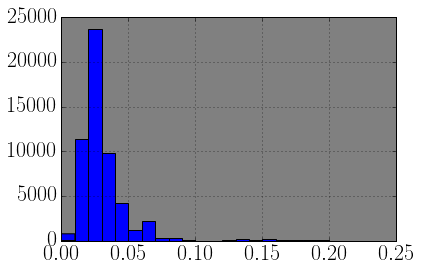

In [53]:
df_eff_el.s_e.hist( range=(0, .20), bins=20).set_axis_bgcolor("grey")

# Muon, Electron pair

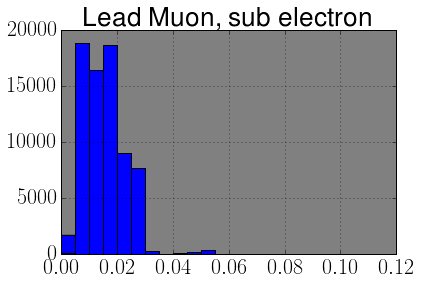

In [52]:
df_eff_me = gen_dilepton_unc(df, l1_typ=13, l2_typ=11)
s_1 = (df_eff_me.high_err_1 + df_eff_me.low_err_1) / 2
s_2 = (df_eff_me.high_err_2 + df_eff_me.low_err_2) / 2
df_eff_me["s_e"] = ( s_1**2 + s_2**2 )**.5 / ( df_eff_me.eff_1 * df_eff_me.eff_2)

df_eff_me.s_e.hist(range=(0,0.1), bins=20).set_axis_bgcolor("grey")
plt.title("Lead Muon, sub electron")


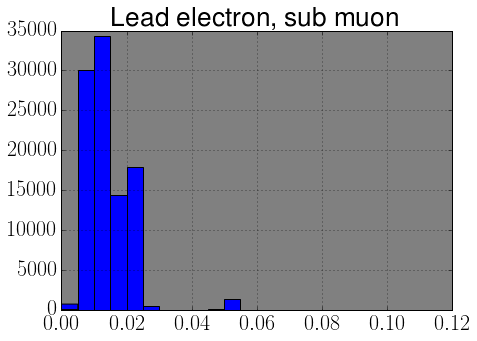

In [51]:
df_eff_em = gen_dilepton_unc(df, l1_typ=11, l2_typ=13)
s_1 = (df_eff_em.high_err_1 + df_eff_em.low_err_1) / 2
s_2 = (df_eff_em.high_err_2 + df_eff_em.low_err_2) / 2
df_eff_em["s_e"] = ( s_1**2 + s_2**2 )**.5 / ( df_eff_em.eff_1 * df_eff_em.eff_2)

df_eff_em.s_e.hist(range=(0,0.1), bins=20, figsize=(7,5)).set_axis_bgcolor("grey")
plt.title("Lead electron, sub muon")

# Summary

Summary:

plots slide by side, mean and variance for each distibution

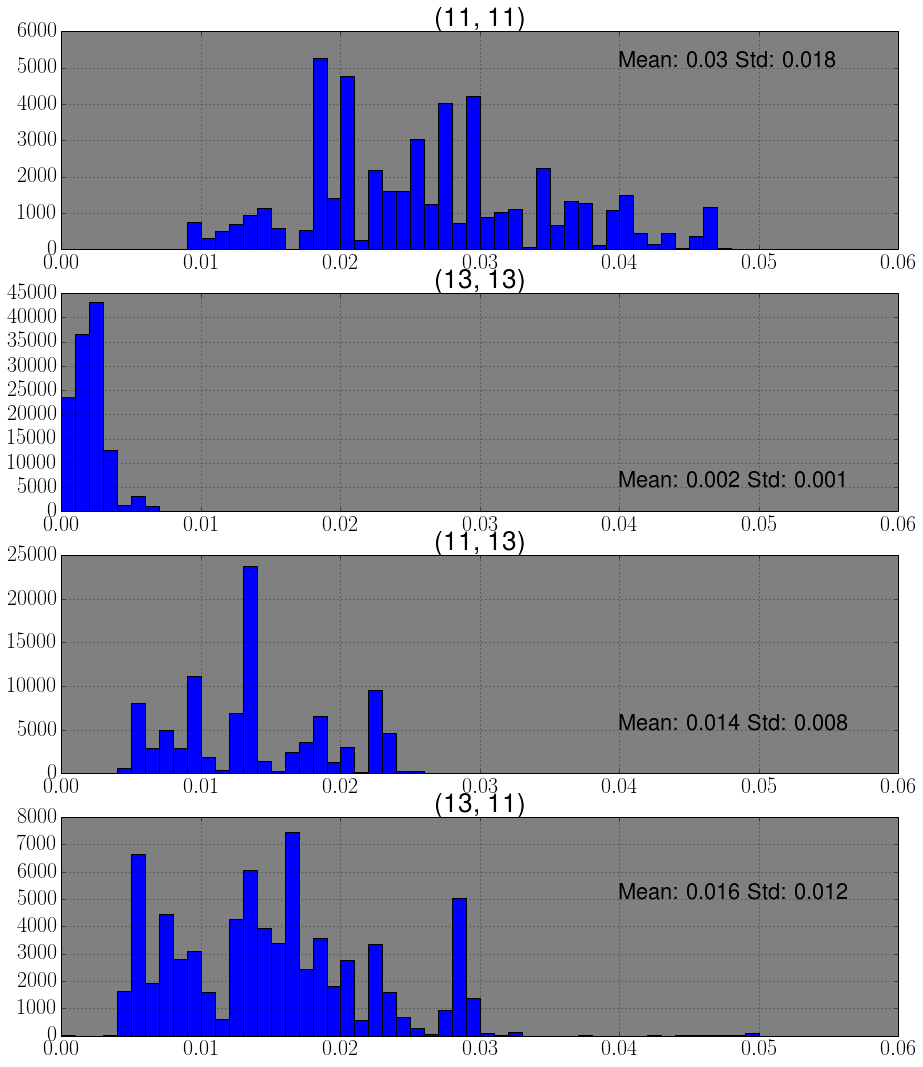

In [72]:
lepton_combinations = [(11,11), (13,13), (11,13), (13,11)]
fig, axes = plt.subplots(4, figsize=(15, 18));

for it, lep_comb in enumerate(lepton_combinations):
    df_eff_tmp = gen_dilepton_unc(df, l1_typ=lep_comb[0], l2_typ=lep_comb[1])
    s_1 = (df_eff_tmp.high_err_1 + df_eff_tmp.low_err_1) / 2
    s_2 = (df_eff_tmp.high_err_2 + df_eff_tmp.low_err_2) / 2
    df_eff_tmp["s_e"] = ( s_1**2 + s_2**2 )**.5 / ( df_eff_tmp.eff_1 * df_eff_tmp.eff_2)

    df_eff_tmp.s_e.hist(range=(0,0.05), bins=50, ax=axes[it])
    axes[it].patch.set_facecolor((.5,.5,.5))
    axes[it].set_title(str(lep_comb))
    axes[it].text(.04, 5000, "Mean: " + str(round(df_eff_tmp.s_e.mean(), 3)) + "\tStd: " + str(round(df_eff_tmp.s_e.std(), 3)) )

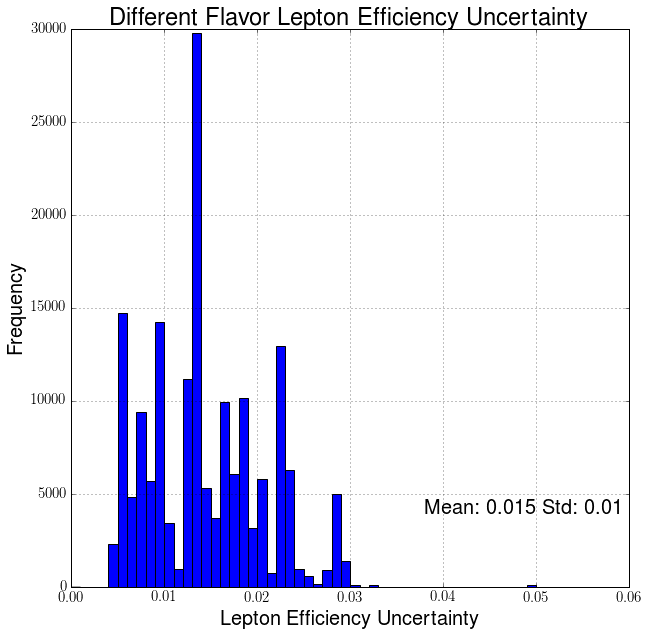

In [28]:

lepton_combinations = [(11,11), (13,13), (11,13), (13,11)]
df_cmb_tmp = pd.concat([gen_dilepton_unc(df, l1_typ=11, l2_typ=13), 
                        gen_dilepton_unc(df, l1_typ=13, l2_typ=11)])


s_1 = (df_cmb_tmp.high_err_1 + df_cmb_tmp.low_err_1) / 2
s_2 = (df_cmb_tmp.high_err_2 + df_cmb_tmp.low_err_2) / 2
df_cmb_tmp["s_e"] = ( s_1**2 + s_2**2 )**.5 / ( df_cmb_tmp.eff_1 * df_cmb_tmp.eff_2)

df_cmb_tmp.s_e.hist(range=(0,0.05), bins=50, figsize=(10,10))
plt.title("Different Flavor Lepton Efficiency Uncertainty", fontsize=24)
plt.ylabel("Frequency", fontsize=20)
plt.xlabel("Lepton Efficiency Uncertainty", fontsize=20)
plt.text(.038, 4000, "Mean: " + str(round(df_cmb_tmp.s_e.mean(), 3)) + "\tStd: " + str(round(df_cmb_tmp.s_e.std(), 3)), fontsize=20 )
plt.tick_params(labelsize=15)

In [12]:
df_cmb_tmp.shape

(172719, 7)

In [14]:
gen_dilepton_unc(df, l1_typ=13, l2_typ=11).shape

(73618, 6)